<a href="https://colab.research.google.com/github/myconcordia/A2I2/blob/main/LSTM_Autoencoder_for_Network_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: LSTM Autoencoder for Network Anomaly Detection**

### **Instructions:**

In this project, we will create and train an LSTM-based autoencoder to detect anomalies in the KDD99 network traffic dataset. 

Note that KDD99 does not include timestamps as a feature. The simplest approach to making these discrete datapoints into time-domain data is to assume that each datapoint occurs at the timestep immediately after the previous datapoint. However, more sophisticated approaches can also be adopted (e.g., grouping by TCP connections). The choice of serialization technique (i.e., conversion into time-domain) is up to you.

This project must be implemented in a Jupyer Notebook, and must be compatible with Google Colab (i.e., if you are using a particular library that is not on Colab by default, your notebook must install it via !pip install ... ). Your notebook must also contain a section on performance analysis, where you report the performance of your IDS model via performance metrics and/or plots (similar to Section 5).

**A very important note:** You should not expect very high detection rates from your model. 

## Read in KDD99 Data Set

In [1]:
#importing required libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path) 

2154496/2144903 [==============================] - 3s 1us/step
/root/.keras/datasets/kddcup.data_10_percent.gz


In [2]:
# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [3]:
# The CSV file has no column heads, so add them
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']

# displaying the contents
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## Data Preprocessing

In [4]:
# For now, just drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1) 
df.shape

(494021, 42)

In [5]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [6]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

## Encoding numeric and text data:

In [7]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [8]:
#encoding the feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

In [9]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,...,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.521415,-1.156639,-0.464089,-0.46352,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.451532,-1.694313,0.599396,-0.282866,-1.022076,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.521415,-1.156639,-0.464089,-0.46352,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.297081,-1.600009,0.599396,-0.282866,-1.146736,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.521415,-1.156639,-0.464089,-0.46352,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.142630,-1.505706,0.599396,-0.282866,-1.188290,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.530798,-1.164758,-0.464089,-0.46352,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-2.988179,-1.411402,0.599396,-0.282866,-1.188290,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.530798,-1.164758,-0.464089,-0.46352,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-2.833728,-1.317098,0.599396,-0.282866,-1.209066,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0


In [10]:
df['protocol_type-tcp'].unique()

array([1, 0], dtype=uint8)

In [11]:
normal_mask = df['outcome']=='normal.'
attack_mask = df['outcome']!='normal.'

df.drop('outcome',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 97278
Attack count: 396743


In [12]:
# This is the numeric feature vector, as it goes to the neural net
x_normal = df_normal.values
x_attack = df_attack.values

In [13]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(x_normal, test_size=0.3, random_state=12)

print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 68094
Normal test count: 29184


In [14]:
x_normal_train.shape, x_normal_test.shape

((68094, 120), (29184, 120))

In [15]:
#Scaling the dataset 
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_normal_train = sc.fit_transform(x_normal_train)
x_normal_test = sc.fit_transform(x_normal_test)
x_normal = sc.fit_transform(x_normal)
x_attack = sc.fit_transform(x_attack)

We already know that the KDD99 dataset doesn't include timestamps as a feature. So, lets consider simplest approach to making these datapoints into time-domain data i.e., to assume that each datapoint occurs at the timestep immediately after the previous datapoint.

In [16]:
x_normal_train = pd.DataFrame(x_normal_train)
x_normal_test = pd.DataFrame(x_normal_test)
x_attack = pd.DataFrame(x_attack)
x_normal = pd.DataFrame(x_normal)

In [17]:
#function to convert to time domain dataset
def create_dataset(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [18]:
# reshape to [samples, time_steps, n_features]

TIME_STEPS = 1
Xnormal_train = create_dataset(x_normal_train, TIME_STEPS)
print(Xnormal_train.shape)

(68093, 1, 120)


In [19]:
Xnormal_test = create_dataset(x_normal_test, TIME_STEPS)
print(Xnormal_test.shape)

(29183, 1, 120)


In [20]:
Xattack = create_dataset(x_attack, TIME_STEPS)
print(Xattack.shape)

(396742, 1, 120)


In [22]:
Xnormal = create_dataset(x_normal,TIME_STEPS)
print(Xattack.shape)

(396742, 1, 120)


## LSTM Autoencoder Model Architecture:

In [23]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(Xnormal_train.shape[1], Xnormal_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.RepeatVector(n=Xnormal_train.shape[1]))
model.add(keras.layers.LSTM(units=32, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=Xnormal_train.shape[2])))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                47360     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 120)            3960      
Total params: 63,736
Trainable params: 63,736
Non-trainable params: 0
____________________________________________________

## LSTM Autoencoder Model Training:

In [24]:
history = model.fit(
    Xnormal_train, Xnormal_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2, 
    shuffle = False
)

Epoch 1/15
426/426 [==============================] - 7s 7ms/step - loss: 0.1056 - accuracy: 0.2083 - val_loss: 0.0635 - val_accuracy: 0.2792
Epoch 2/15
426/426 [==============================] - 2s 6ms/step - loss: 0.0647 - accuracy: 0.3127 - val_loss: 0.0510 - val_accuracy: 0.2940
Epoch 3/15
426/426 [==============================] - 2s 6ms/step - loss: 0.0594 - accuracy: 0.3510 - val_loss: 0.0484 - val_accuracy: 0.2849
Epoch 4/15
426/426 [==============================] - 3s 6ms/step - loss: 0.0559 - accuracy: 0.3596 - val_loss: 0.0459 - val_accuracy: 0.2847
Epoch 5/15
426/426 [==============================] - 2s 6ms/step - loss: 0.0530 - accuracy: 0.3974 - val_loss: 0.0445 - val_accuracy: 0.3513
Epoch 6/15
426/426 [==============================] - 3s 6ms/step - loss: 0.0511 - accuracy: 0.4120 - val_loss: 0.0435 - val_accuracy: 0.3591
Epoch 7/15
426/426 [==============================] - 2s 6ms/step - loss: 0.0497 - accuracy: 0.4172 - val_loss: 0.0430 - val_accuracy: 0.3582
Epoch 

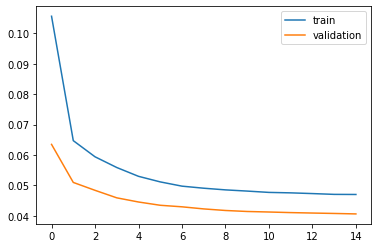

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## Model Evaluation:

In [26]:
X_train_pred = model.predict(Xnormal_train)

train_mae_loss = np.mean(np.abs(X_train_pred - Xnormal_train), axis=1)
train_mae_loss.shape

(68093, 120)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


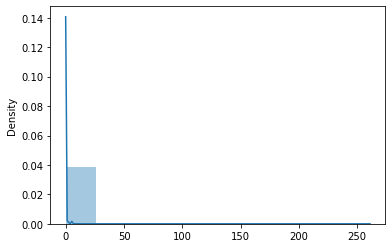

In [36]:
sns.distplot(train_mae_loss, bins = 10, kde=True);

In [37]:
X_test_pred = model.predict(Xnormal_test)

test_mae_loss = np.mean(np.abs(X_test_pred - Xnormal_test), axis=1)
test_mae_loss.shape

(29183, 120)

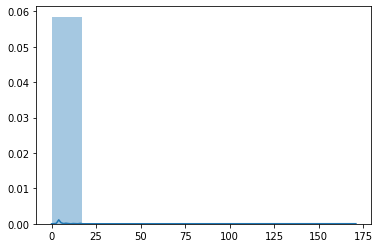

In [ ]:
sns.distplot(test_mae_loss, bins=10, kde=True);

In [ ]:
X_normal_pred = model.predict(Xnormal)

normal_mae_loss = np.mean(np.abs(X_normal_pred - Xnormal), axis=1)
normal_mae_loss.shape

(97277, 120)

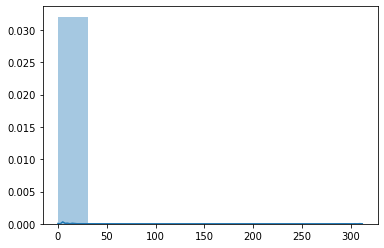

In [ ]:
sns.distplot(normal_mae_loss, bins=10, kde=True);

In [ ]:
X_attack_pred = model.predict(Xattack)

attack_mae_loss = np.mean(np.abs(X_attack_pred - Xattack), axis=1)
attack_mae_loss.shape

(396742, 120)

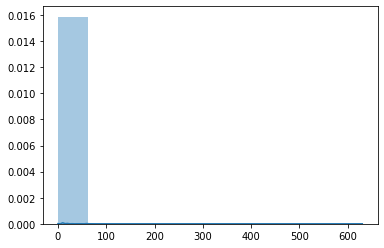

In [ ]:
sns.distplot(attack_mae_loss, bins=10, kde=True);

In [ ]:
score1 = model.evaluate(Xnormal_train, Xnormal_train)
print("\n Sample Loss(MAE) & Accuracy Scores (Train):", score1[0], score1[1], "\n") 

score2 = model.evaluate(Xnormal_test, Xnormal_test)
print("\nOut of Sample Loss(MAE) & Accuracy Scores (Test):", score2[0], score2[1], "\n") 

score3 = model.evaluate(Xattack, Xattack)
print("\nAttack Underway Loss(MAE) & Accuracy Scores (Anomaly):", score3[0], score3[1], "\n") 

2128/2128 [==============================] - 4s 2ms/step - loss: 0.0375 - accuracy: 0.4870

 Sample Loss(MAE) & Accuracy Scores (Train): 0.03754130378365517 0.48695167899131775 

912/912 [==============================] - 2s 2ms/step - loss: 0.0482 - accuracy: 0.4840

Out of Sample Loss(MAE) & Accuracy Scores (Test): 0.04821811988949776 0.4839803874492645 

12399/12399 [==============================] - 24s 2ms/step - loss: 0.1700 - accuracy: 0.0047

Attack Underway Loss(MAE) & Accuracy Scores (Anomaly): 0.16998399794101715 0.004738595802336931 



**Conclusion:** The accuracy of model prediction on normal train and test sets is almost similarm aroung 0.48. Where as the model accuracy when trained on the anomaly or attack data is 0.0047 which is no way comaprable to the normal data accuracy. 

It is the same even with the loss, Mean Absolute Error (mae). The normal train and test sets have mae around 0.04 and the anomaly ot attack data has a mae of 0.16. From this we can detect the anomaly if any in the data. 